In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import torch
from itertools import count

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
### If notebook not at root of knossos:
import os
os.chdir('/home/t-mbruno/projects/knossos')  # Path to knossos repo

In [4]:
from rlo import factory
from rlo.expression import Expression
from rlo import expr_sets
from train_on_dataset import get_symtab_free_var_types
from rlo.dataset import StateValueDataset
from rlo.expression_util import make_toplevel
from rlo import sparser
from rlo.pipelines import graph_pipeline
from rlo.pipelines.training_pipeline import _spec_to_input
from rlo.torch_dataset import MultiEdgeTypeBatch
from rlo.model.layers import GRU, GRUCell

In [5]:
%matplotlib inline

##### Manually specify configs for the torch and TF regressors

In [6]:
tf_config = {
    "eager": True,
    "scenario": "binding_simplify_astar",
    "run_id": "binding_simplify_astar_2021_05_27_09_52_35_17255",
    "gitlog": "41043ebc@t-salewi/pytorch-dummy+local_changes",
    "output_dir": "outputs",
    "force_gpu": False,
    "gpu_memory_fraction": None,
    "save_all_models": False,
    "num_parallel": 1,
    "dataset_path": "datasets/value_dataset.json",
    "dist_plots": None,
    "cost_bins": 10,
    "value_bins": 10,
    "node_bins": 10,
    "exprs_per_generation": 0,
    "use_subtree_match_edges": True,
    "num_propagations": 10,  # Changed for debugging
    "nonlinear_messages": False,
    "aggregation_over_edge_types": "sum",
    "decoder_readout": "sum",
    "message_from_sender_receiver": False,
    "one_hot_embedding": False,
    "hidden_dim": 200,
    "output_hidden_dim": 200,
    "gamma": 0.1,
    "max_num_episodes_train": 4096,
    "max_num_episodes_eval": 100,
    "num_positive_examples": 10,
    "simulation_depth": 11,
    "maxing": "accumulator",
    "min_epochs": 10,
    "max_epochs": 30,
    "num_repetitions": 8,
    "graph_state_keep_prob": 1.0, # Changed to no dropout!
    "output_keep_prob": 1.0, # Changed to no dropout!
    "cost_normalization": None,
    "patience_epochs": 4,
    "num_generations": None,
    "total_train_time": 3600,
    "num_episode_clusters": 5,
    "template_path": None,
    "test_on_defs": None,
    "train_on_defs": None,
    "seed_all_reps": None,
    "loss": "pinball=0.9",
    "lr": 0.0001,
    "grad_clip_value": 0,
    "split": 0.9,
    "value_bin_splits": None,
    "time_bin_splits": None,
    "episode_bin_splits": None,
    "extra_plots": [],
    "v2": False,
    "verbose": True,
    "dataset_refiners": ["best_across_generations_refiner"],
    "train_search": "astar",
    "eval_search": "astar",
    "cost_per_step": None,
    "max_gnn_train": 1000,
    "max_gnn_eval": 1000,
    "search_batch_size": 16,
    "hybrid_merge_handling": "STOP",
    "hybrid_prob_rollout": 1.0,
    # "hybrid_alpha": inf,
    "alpha_test": 5.0,
    "init_alpha": 1.0,
    "alpha_scaling_factor": 1.1,
    "alpha_scaling_factor_fail": 1.0,
    "sparse_gnn": True,
    "tensorflow": True,
    "num_gnn_blocks": 1,
    "stacked_gnn_double_hidden": False,
    "max_nodes_per_batch": 10000,
    "cumsum": None,
    "two_value_func": None,
    "two_value_func_var_frac_train": None,
    "rules": "binding_simplify_rules",
    "test_exprs": "binding_simplify_expressions",
    "train_exprs": "binding_simplify_expressions",
    "oracle": True,
    "extra_scenario_params": "+decoder_readout:sum+max_epochs:30+loss:pinball=0.9+tensorflow:True",
    "result_save_path": "outputs/Run_binding_simplify_astar_2021_05_27_09_52_35_17255/0",
    "repetition": 0,
}
torch_config = {
    "scenario": "binding_simplify_astar",
    "run_id": "binding_simplify_astar_2021_05_27_09_55_40_17647",
    "gitlog": "41043ebc@t-salewi/pytorch-dummy+local_changes",
    "output_dir": "outputs",
    "force_gpu": False,
    "gpu_memory_fraction": None,
    "save_all_models": False,
    "num_parallel": 1,
    "dataset_path": "datasets/value_dataset.json",
    "dist_plots": None,
    "cost_bins": 10,
    "value_bins": 10,
    "node_bins": 10,
    "exprs_per_generation": 0,
    "use_subtree_match_edges": True,
    "num_propagations": 10,  # Changed for debugging
    "nonlinear_messages": False,
    "aggregation_over_edge_types": "sum",
    "decoder_readout": "sum",
    "message_from_sender_receiver": False,
    "one_hot_embedding": False,
    "hidden_dim": 200,
    "output_hidden_dim": 200,
    "gamma": 0.1,
    "max_num_episodes_train": 4096,
    "max_num_episodes_eval": 100,
    "num_positive_examples": 10,
    "simulation_depth": 11,
    "maxing": "accumulator",
    "min_epochs": 10,
    "max_epochs": 30,
    "num_repetitions": 8,
    "graph_state_keep_prob": 1.0,  # Changed to no dropout!
    "output_keep_prob": 1.0, # Changed to no dropout!
    "cost_normalization": None,
    "patience_epochs": 4,
    "num_generations": None,
    "total_train_time": 3600,
    "num_episode_clusters": 5,
    "template_path": None,
    "test_on_defs": None,
    "train_on_defs": None,
    "seed_all_reps": None,
    "loss": "pinball=0.9",
    "lr": 0.0001,
    "grad_clip_value": 0,
    "split": 0.9,
    "value_bin_splits": None,
    "time_bin_splits": None,
    "episode_bin_splits": None,
    "extra_plots": [],
    "v2": False,
    "verbose": True,
    "dataset_refiners": ["best_across_generations_refiner"],
    "train_search": "astar",
    "eval_search": "astar",
    "cost_per_step": None,
    "max_gnn_train": 1000,
    "max_gnn_eval": 1000,
    "search_batch_size": 16,
    "hybrid_merge_handling": "STOP",
    "hybrid_prob_rollout": 1.0,
    # "hybrid_alpha": inf,
    "alpha_test": 5.0,
    "init_alpha": 1.0,
    "alpha_scaling_factor": 1.1,
    "alpha_scaling_factor_fail": 1.0,
    "sparse_gnn": True,
    "tensorflow": False,
    "num_gnn_blocks": 1,
    "stacked_gnn_double_hidden": False,
    "max_nodes_per_batch": 10000,
    "cumsum": None,
    "two_value_func": None,
    "two_value_func_var_frac_train": None,
    "test_exprs": "binding_simplify_expressions",
    "rules": "binding_simplify_rules",
    "train_exprs": "binding_simplify_expressions",
    "oracle": True,
    "extra_scenario_params": "+decoder_readout:sum+max_epochs:30+loss:pinball=0.9",
    "result_save_path": "outputs/Run_binding_simplify_astar_2021_05_27_09_55_40_17647/0",
    "repetition": 0,
}


### Prepare (create) the tensorflow and torch models

In [7]:
# Construct the two models that should be the same
# First the tf_model
tf_model = factory.regressor_from_config(tf_config)

In [8]:
# Then the torch model
torch_model = factory.regressor_from_config(torch_config)

##### Load the data into a framework-agnostic dataset

In [9]:
# Load some data
with open('datasets/value_dataset.json') as f:
    dataset = json.load(f)['data_points']

symtab, free_var_types = get_symtab_free_var_types(
        expr_sets.get_expression_set(torch_config["train_exprs"])
    )

dataset = StateValueDataset.build_from_triples(
    (
        t,
        make_toplevel(
            sparser.parse_expr(expr_str),
            symtab=symtab,
            free_var_types=free_var_types,
        ),
        v,
    )
    for t, expr_str, v in dataset
)

raw_examples = dataset.get_examples()

In [10]:
raw_examples[0]

RawValueExample(exprtab=ExprWithSymtab(expr=EF.Add(1.0, EF.Mul(1.0, Expression.Variable("x", Type.Float))), symtab={}), values=array([0., 2.]))

##### Load the data-loading utilities for torch and tf

In [11]:
# Torch data converter
data_converter = factory.data_converter_from_config(torch_config)
torch_graph = data_converter.prepare_exprtab(raw_examples[0][0])
print(torch_graph)

MultiEdgeTypeGraphData(edge_indices=[9], x=[5])


In [12]:
# Tensorflow data converter
pipeline = graph_pipeline.SparsePipeline(use_subtree_match_edges=tf_config['use_subtree_match_edges'])
np_graph = pipeline.prepare_example(raw_examples[0][0])

In [13]:
# Assert the two are the same
# There are 9 edge types
assert len(np_graph.edge_indices) == len(torch_graph.edge_indices) == 9
# Torch and numpy edges should be the same, just transposed.
for np_edges, torch_edges in zip(np_graph.edge_indices, torch_graph.edge_indices):
    np.testing.assert_equal(np_edges.T, torch_edges.numpy())


In [14]:

# pipeline.batched_spec
inputs = tf.nest.map_structure(_spec_to_input, pipeline.batched_spec)
# print(inputs.keys())
tf_model.keras_model.build_and_compile(inputs=inputs)
tf_model.keras_model.built = True  # Otherwise we get ValueError. build_and_compile method says something about why it calls 'call' not 'build'
tf_model.keras_model.summary()

Model: "gnn_state_value_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sparse_gnn_encoder (SparseGN (None, 400)               608600    
_________________________________________________________________
gated_regression (GatedRegre (None, 12)                83013     
Total params: 691,613
Trainable params: 691,613
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(torch_model.model)


StateValueModel(
  (encoder): GNNEncoder(
    (embedding): Embedding(28, 200)
    (gnn): StackedRelationalGNN(
      (gnn_blocks): ModuleList(
        (0): RelationalGatedGraphConv(
          (rnn): DropoutGRUCell(200, 200)
          (edge_transformations): ModuleList(
            (0): Linear(in_features=200, out_features=200, bias=True)
            (1): Linear(in_features=200, out_features=200, bias=True)
            (2): Linear(in_features=200, out_features=200, bias=True)
            (3): Linear(in_features=200, out_features=200, bias=True)
            (4): Linear(in_features=200, out_features=200, bias=True)
            (5): Linear(in_features=200, out_features=200, bias=True)
            (6): Linear(in_features=200, out_features=200, bias=True)
            (7): Linear(in_features=200, out_features=200, bias=True)
            (8): Linear(in_features=200, out_features=200, bias=True)
          )
        )
      )
    )
  )
  (regressor): GatedRegression(
    (mlp): Sequential(
     

In [16]:
def num_parameters(m):
    return sum(np.prod(p.shape) for p in m.parameters())

print('Whole torch model', num_parameters(torch_model.model))
print('Torch encoder', num_parameters(torch_model.model.encoder))   # We have an extra 600 params in encoder
print('Torch regressor', num_parameters(torch_model.model.regressor))

Whole torch model 691613
Torch encoder 608600
Torch regressor 83013


### Print-out and compare shapes of parameter tensors for each layer

In [17]:
def summarise_tf_weights_shapes(weights):
    for weight in weights:
        print(f"{weight.name:<70}\t{weight.shape}")
        
def summarise_torch_weights_shapes(model: torch.nn.Module):
    for name, param in torch_model.model.named_parameters():
        print(f"{name:<70}\t{param.shape}")

In [18]:
print("-" * 10 + " Tensorflow " + "-" * 10)
summarise_tf_weights_shapes(tf_model.keras_model.weights)
print("-" * 10 + " Torch " + "-" * 10)
summarise_torch_weights_shapes(torch_model.model)

---------- Tensorflow ----------
sparse_gnn_encoder/embedding/embeddings:0                             	(28, 200)
sparse_gnn_encoder/sparse_gnn/kernel0:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel1:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel2:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel3:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel4:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel5:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel6:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel7:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/kernel8:0                               	(200, 200)
sparse_gnn_encoder/sparse_gnn/bias:0                                  	(9, 200)
sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/kernel:0              

##### Helper function for getting keras parameters by name:

In [19]:
def get_param_by_name(keras_model, param_name):
    params = [x.numpy() for x in keras_model.weights if x.name == param_name]
    if len(params) == 0:
        raise ValueError(f"No such parameter {param_name} in model.")
    elif len(params) > 1:
        raise ValueError(f"There are multiple parameters matching name {param_name}")
    return params[0]

#### Make plots comparing parameter distributions in each layer

###### Embeddding layer

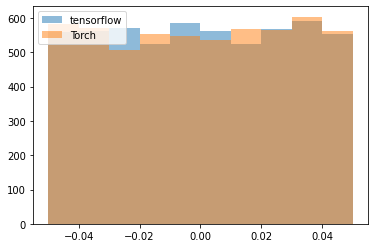

In [20]:
# Compare embeddings
embedding_weights_tf = get_param_by_name(tf_model.keras_model, "sparse_gnn_encoder/embedding/embeddings:0")
embedding_weights_torch = torch_model.model.encoder.embedding.weight.detach().numpy()
plt.hist(embedding_weights_tf.ravel(), alpha=0.5, label="tensorflow")
plt.hist(embedding_weights_torch.ravel(), alpha=0.5, label="Torch")
plt.legend()

In [21]:
# embedding = torch.nn.Embedding(num_embeddings=28, embedding_dim=200)
# torch.nn.init.xavier_uniform_(embedding.weight)
# plt.hist(embedding.weight.detach().numpy().ravel(), bins=40);

###### Message functions

In [22]:
num_edge_types = torch_model.model.encoder.gnn.gnn_blocks[0]._num_edge_types

<ipython-input-23-e132eb9c9701>:19: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axes[i, 1].set_xlim(kernel_bias_torch.min(), kernel_bias_torch.max())


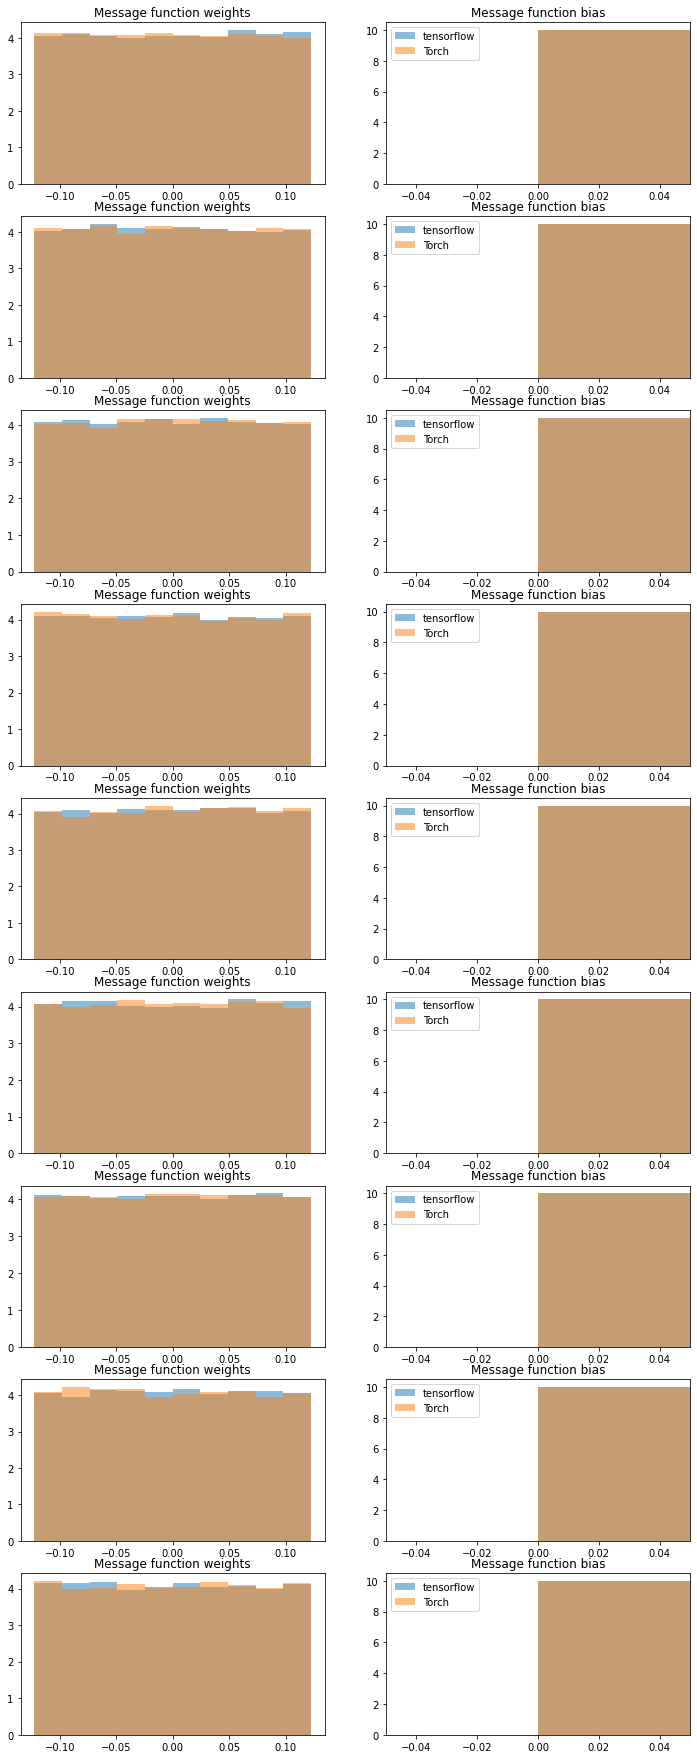

In [23]:
# Compare message_functions
fig, axes = plt.subplots(ncols=2, nrows=num_edge_types, figsize=(12,3.5 * num_edge_types))

for i in range(num_edge_types):
    kernel_weights_tf = next(x.numpy() for x in tf_model.keras_model.weights if x.name == f"sparse_gnn_encoder/sparse_gnn/kernel{i}:0")
    kernel_bias_tf = next(x.numpy() for x in tf_model.keras_model.weights if x.name == f"sparse_gnn_encoder/sparse_gnn/bias:0")[i]
#     print(kernel_bias_torch)

    kernel_weights_torch = next(
        x.detach().numpy() for name, x in torch_model.model.named_parameters() if name == f"encoder.gnn.gnn_blocks.0.edge_transformations.{i}.weight")
    kernel_bias_torch = next(
        x.detach().numpy() for name, x in torch_model.model.named_parameters() if name == f"encoder.gnn.gnn_blocks.0.edge_transformations.{i}.bias")
    
    axes[i, 0].hist(kernel_weights_tf.ravel(), alpha=0.5, label="tensorflow", density=True)
    axes[i, 0].hist(kernel_weights_torch.ravel(), alpha=0.5, label="Torch", density=True)
    axes[i, 0].set_title("Message function weights")
    axes[i, 1].hist(kernel_bias_tf.ravel(), alpha=0.5, label="tensorflow", density=True)
    axes[i, 1].hist(kernel_bias_torch.ravel(), alpha=0.5, label="Torch", density=True)
    axes[i, 1].set_xlim(kernel_bias_torch.min(), kernel_bias_torch.max())
    axes[i, 1].set_title("Message function bias")
    axes[i, 1].legend()

In [24]:
# Is kernel bias in tensorflow == 0 for all?
kernel_bias_tf = next(x.numpy() for x in tf_model.keras_model.weights if x.name == f"sparse_gnn_encoder/sparse_gnn/bias:0")
print(np.all(kernel_bias_tf.ravel() == 0.))

True


###### Print histograms for all parameter tensors (TORCH)

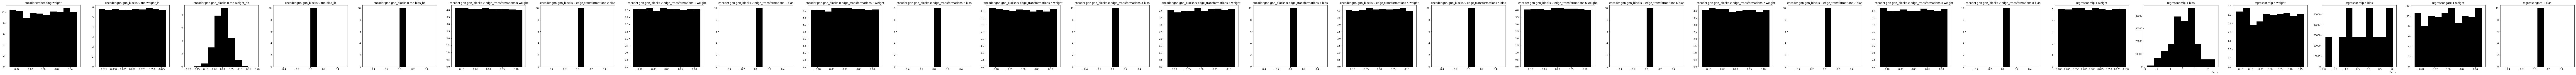

In [25]:

num_param_tensors = len(list(torch_model.model.parameters()))
color = "black"
fig, axes = plt.subplots(ncols=num_param_tensors, nrows=1, figsize=(7 * num_param_tensors,5))

for i, (name, param) in enumerate(torch_model.model.named_parameters()):
    axes[i].hist(param.detach().numpy().ravel(), color=color, density=True)
    axes[i].set_title(name)

###### Print histograms for all parameter tensors (TENSORFLOW)

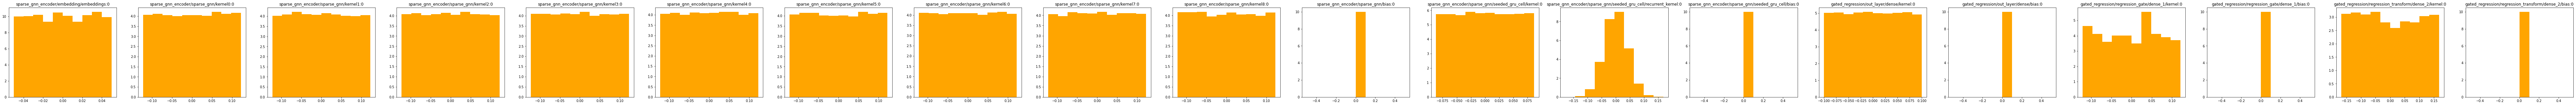

In [26]:
# Compare message_functions
num_param_tensors = len(list(tf_model.keras_model.weights))
color = "orange"
fig, axes = plt.subplots(ncols=num_param_tensors, nrows=1, figsize=(7 * num_param_tensors,5))

for i, weight in enumerate(tf_model.keras_model.weights):
    axes[i].hist(weight.numpy().ravel(), color=color, density=True)
    axes[i].set_title(weight.name)

### Specify matching sets of parameters:

In [27]:
# Helper to print out parameter name for copy pasting later in the code

def summarise_tf_weights_names(weights):
    for weight in weights:
        print(f"{weight.name:<70}")
        
def summarise_torch_weights_names(model: torch.nn.Module):
    for name, param in torch_model.model.named_parameters():
        print(f"{name:<70}")
        
summarise_tf_weights_names(tf_model.keras_model.weights)
print("-"*40)
summarise_torch_weights_names(torch_model.model)

sparse_gnn_encoder/embedding/embeddings:0                             
sparse_gnn_encoder/sparse_gnn/kernel0:0                               
sparse_gnn_encoder/sparse_gnn/kernel1:0                               
sparse_gnn_encoder/sparse_gnn/kernel2:0                               
sparse_gnn_encoder/sparse_gnn/kernel3:0                               
sparse_gnn_encoder/sparse_gnn/kernel4:0                               
sparse_gnn_encoder/sparse_gnn/kernel5:0                               
sparse_gnn_encoder/sparse_gnn/kernel6:0                               
sparse_gnn_encoder/sparse_gnn/kernel7:0                               
sparse_gnn_encoder/sparse_gnn/kernel8:0                               
sparse_gnn_encoder/sparse_gnn/bias:0                                  
sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/kernel:0                
sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/recurrent_kernel:0      
sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/bias:0                  
gated_

In [288]:
# torch_to_tensorflow_param_name_dict =
def assign_tf_weights_to_torch_model(model: torch.nn.Module, keras_model):
    state_dict = model.state_dict()
    for i in range(num_edge_types):
        state_dict[f"encoder.gnn.gnn_blocks.0.edge_transformations.{i}.bias"] = torch.FloatTensor(
            get_param_by_name(keras_model, f"sparse_gnn_encoder/sparse_gnn/bias:0")[i]
        ).clone()
        state_dict[f"encoder.gnn.gnn_blocks.0.edge_transformations.{i}.weight"] = torch.FloatTensor(
            get_param_by_name(keras_model, f"sparse_gnn_encoder/sparse_gnn/kernel{i}:0")
        ).clone().T
    state_dict[f"encoder.embedding.weight"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"sparse_gnn_encoder/embedding/embeddings:0")
    ).clone()
    state_dict[f"regressor.mlp.1.weight"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/out_layer/dense/kernel:0")
    ).clone().T
    state_dict[f"regressor.mlp.1.bias"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/out_layer/dense/bias:0")
    ).clone()
    
    state_dict[f"regressor.mlp.3.weight"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/regression_transform/dense_2/kernel:0")
    ).clone().T
    state_dict[f"regressor.mlp.3.bias"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/regression_transform/dense_2/bias:0")
    ).clone()
    
    state_dict[f"regressor.gate.1.weight"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/regression_gate/dense_1/kernel:0")
    ).clone().T
    state_dict[f"regressor.gate.1.bias"] = torch.FloatTensor(
        get_param_by_name(keras_model, f"gated_regression/regression_gate/dense_1/bias:0")
    ).clone()
    # ------ RNN -----
    # The weights are out of order.
    # In Torch they are ordered as weigts for 1) reset gate, 2) update/input gate 3) candidate activation
    # In TF they are ordered as 1) update/input gate 2) reset gate 3) candidate_activation
    weights_ih_out_of_order = torch.FloatTensor(
        get_param_by_name(
            keras_model,
            f"sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/kernel:0"
        )
    ).clone().T
    weights_ih_update, weights_ih_reset, weights_ih_h = weights_ih_out_of_order.chunk(3, dim=0)
    weights_ih_in_order = torch.cat((weights_ih_reset, weights_ih_update, weights_ih_h), dim=0)
    state_dict[f"encoder.gnn.gnn_blocks.0.rnn.weight_ih"] = weights_ih_in_order
    
    weights_hh_out_of_order = torch.FloatTensor(
        get_param_by_name(
            keras_model,
            f"sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/recurrent_kernel:0"
        )
    ).clone().T
    
    weights_hh_update, weights_hh_reset, weights_hh_h = weights_hh_out_of_order.chunk(3, dim=0)
    weights_hh_in_order = torch.cat((weights_hh_reset, weights_hh_update, weights_hh_h), dim=0)
    state_dict[f"encoder.gnn.gnn_blocks.0.rnn.weight_hh"] = weights_hh_in_order
    
    if keras_model.encoder.gnn.gru_cell.reset_after:  # Can transfer the bias as well
        # Assign input_bias
        bias_ih_out_of_order = torch.FloatTensor(
            get_param_by_name(
                keras_model,
                f"sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/bias:0"
            )
        )[0].clone()
        bias_ih_update, bias_ih_reset, bias_ih_h = bias_ih_out_of_order.chunk(3, dim=0)
        bias_ih_in_order = torch.cat((bias_ih_reset, bias_ih_update, bias_ih_h), dim=0)
        state_dict[f"encoder.gnn.gnn_blocks.0.rnn.bias_ih"] = bias_ih_in_order
        # Assign recurrent bias
        bias_hh_out_of_order = torch.FloatTensor(
            get_param_by_name(
                keras_model,
                f"sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/bias:0"
            )
        )[1].clone()
        bias_hh_update, bias_hh_reset, bias_hh_h = bias_hh_out_of_order.chunk(3, dim=0)
        bias_hh_in_order = torch.cat((bias_hh_reset, bias_hh_update, bias_hh_h), dim=0)
        state_dict[f"encoder.gnn.gnn_blocks.0.rnn.bias_hh"] = bias_hh_in_order
    model.load_state_dict(state_dict)
    return

##### Assign TF parameters to torch model

In [289]:
assign_tf_weights_to_torch_model(torch_model.model, tf_model.keras_model)

In [290]:
# Verify that some parameters are indeed the same
print(torch_model.model.encoder.embedding.weight)
print(get_param_by_name(tf_model.keras_model, "sparse_gnn_encoder/embedding/embeddings:0"))

Parameter containing:
tensor([[-0.0208, -0.0293,  0.0035,  ...,  0.0187, -0.0431, -0.0314],
        [ 0.0104, -0.0050,  0.0056,  ..., -0.0013,  0.0340, -0.0174],
        [ 0.0323, -0.0041,  0.0365,  ...,  0.0412, -0.0455,  0.0333],
        ...,
        [-0.0048,  0.0300, -0.0146,  ..., -0.0254, -0.0376, -0.0018],
        [ 0.0192,  0.0006, -0.0426,  ...,  0.0281,  0.0048,  0.0291],
        [-0.0328,  0.0254,  0.0105,  ..., -0.0303, -0.0154, -0.0356]],
       requires_grad=True)
[[-0.02080249 -0.02934336  0.00353907 ...  0.01869451 -0.04313255
  -0.03135297]
 [ 0.01043357 -0.00502661  0.00555401 ... -0.001256    0.03399781
  -0.01744902]
 [ 0.03225327 -0.00414773  0.03647459 ...  0.04116226 -0.04553255
   0.03330525]
 ...
 [-0.00480708  0.03002764 -0.01460622 ... -0.02539953 -0.03755035
  -0.00184938]
 [ 0.0191831   0.00057225 -0.04257597 ...  0.02812887  0.00481988
   0.0290689 ]
 [-0.03284771  0.02542551  0.01052675 ... -0.03029718 -0.01537487
  -0.03556461]]


## Compare outputs of RNN only

[ 0.6547965   0.2143265   0.9567812   0.05001095  0.7776345  -0.34138033
  0.5413889  -0.02433655  0.5152026   0.8015357   0.70760727  0.9634391
  0.8804648   0.48708665  0.21247023  0.9193822   0.7478925   0.75939167
  0.62107956 -0.26546514  0.7371021   0.60132223 -0.43666953  0.68862736
  0.8184533   0.7979003  -0.38390476 -0.40433648  0.3647192   0.51759404
 -0.0381273   0.29416582  0.7586001   0.40486145  0.66722405  0.40518743
  0.65989965  0.2454567   0.97283244  0.8604498 ]


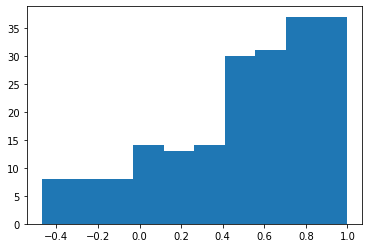

In [291]:
y = tf_model.keras_model.encoder.gnn.gru_cell(tf.ones([1, 200]), tf.ones([1, 200]))[0]
y_tf = y.numpy().ravel()
plt.hist(y_tf);
print(y_tf[:40])

[ 0.6547966   0.21432644  0.9567812   0.05001098  0.7776345  -0.34138018
  0.541389   -0.02433658  0.5152026   0.80153567  0.70760727  0.96343905
  0.8804648   0.4870866   0.21247017  0.9193822   0.7478925   0.75939167
  0.62107944 -0.26546532  0.73710203  0.6013225  -0.43666947  0.68862736
  0.8184533   0.7979003  -0.38390476 -0.40433642  0.36471915  0.517594
 -0.03812736  0.29416597  0.7586      0.4048615   0.66722405  0.40518743
  0.6598997   0.24545681  0.97283244  0.86044973]


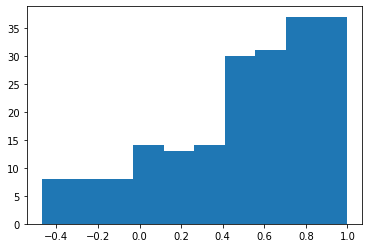

In [292]:
y = torch_model.model.encoder.gnn.gnn_blocks[0].rnn(torch.ones(1, 200), torch.ones(1, 200))
y_torch = y.detach().numpy().ravel()
plt.hist(y_torch);
print(y_torch[:40])

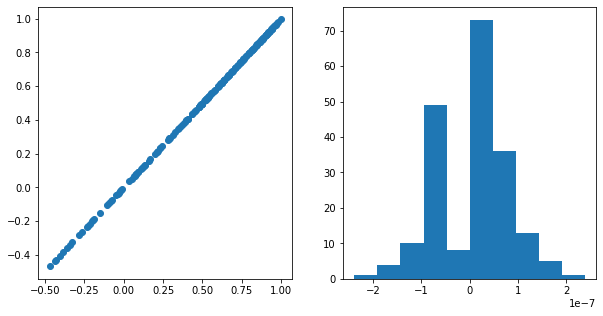

In [293]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(y_torch, y_tf)
axes[1].hist(y_torch - y_tf)
axes[1].set_label("Absolute error")

#### Compare against a custom GRU Cell

In [33]:
# Custom GRU in torch
gru = GRUCell(200, 200, bias=True)
gru.weight_hh = torch_model.model.encoder.gnn.gnn_blocks[0].rnn.weight_hh
gru.weight_ih = torch_model.model.encoder.gnn.gnn_blocks[0].rnn.weight_ih
gru.bias_hh = torch_model.model.encoder.gnn.gnn_blocks[0].rnn.bias_hh
gru.bias_ih = torch_model.model.encoder.gnn.gnn_blocks[0].rnn.bias_ih

[[ 0.64874846  0.21296489  0.95786345  0.03955358  0.7743926  -0.33767405
   0.538553   -0.02326638  0.51222193  0.80539376  0.70152617  0.96361893
   0.8795121   0.49096203  0.21682405  0.9187782   0.75142395  0.75969005
   0.6205926  -0.2597428   0.7459213   0.6043347  -0.42429763  0.6965665
   0.8154949   0.7988301  -0.37966248 -0.40017653  0.3614829   0.5073778
  -0.04236978  0.3000062   0.76863635  0.41633075  0.66251695  0.4182402
   0.6544703   0.23694324  0.9723063   0.8610525 ]]


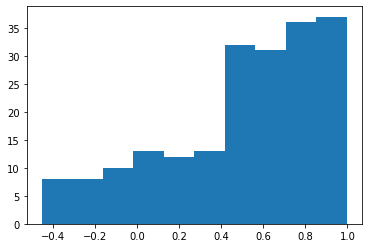

In [34]:
y = gru(torch.ones(1, 200), torch.ones(1, 200))
plt.hist(y.detach().numpy().ravel());
print(y.detach().numpy()[:, :40])

###### Assign custom weights to TF model RNN

In [35]:
# kernel_weights = np.zeros([200, 600])
# kernel_weights[:, 400:] = np.random.randn(200, 200)
# kernel_weights[:, 200:400] = np.random.randn(200, 200)

# recurrent_weights = np.zeros([200, 600])
# recurrent_weights[:, 400:] = np.random.randn(200, 200)
# tf_model.keras_model.encoder.gnn.gru_cell.weights[0].assign(kernel_weights)
# tf_model.keras_model.encoder.gnn.gru_cell.weights[1].assign(recurrent_weights)
# tf_model.keras_model.encoder.gnn.gru_cell.weights[2].assign(tf.zeros([2, 600]))
# tf_model.keras_model.encoder.gnn.gru_cell.weights[0]

### Compare output distributions

In [199]:
np_graph = pipeline.prepare_example(raw_examples[0][0])
torch_graph = data_converter.prepare_exprtab(raw_examples[0][0])

In [200]:
def prepare_tf_input(raw_example):
    np_graph = pipeline.prepare_example(raw_example[0])
    tf_input = tf.nest.map_structure(tf.convert_to_tensor, np_graph._asdict())
    tf_input['node_type'] = tf_input['node_reps']
    tf_input['node_row_splits'] = [0, len(tf_input['node_reps'])]
    tf_input['adjacency'] = tf_input['edge_indices']
    del tf_input['node_reps']
    del tf_input['edge_indices']
    return tf_input, raw_example[1]

In [201]:
# -- Convert examples
# First make a TF input batch
tf_input, _ = prepare_tf_input(raw_examples[0])
print('tf_input', tf_input)

tf_input {'node_type': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 1,  6, 18,  6, 27], dtype=int32)>, 'node_row_splits': [0, 5], 'adjacency': (<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 1],
       [2, 3]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 0],
       [3, 2]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 2],
       [2, 4]], dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 0],
       [4, 2]], dtype=int32)>, <tf.Tensor: shape=(0, 2), dtype=int32, numpy=array([], shape=(0, 2), dtype=int32)>, <tf.Tensor: shape=(0, 2), dtype=int32, numpy=array([], shape=(0, 2), dtype=int32)>, <tf.Tensor: shape=(0, 2), dtype=int32, numpy=array([], shape=(0, 2), dtype=int32)>, <tf.Tensor: shape=(0, 2), dtype=int32, numpy=array([], shape=(0, 2), dtype=int32)>, <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3, 1],
       [1, 3]], dtype=int32)>)}


In [202]:
# Then make a torch
print('torch data', torch_graph.x, torch_graph.edge_indices)
tf_output = tf_model.keras_model(tf_input, training=False)

print('tf model outputs', tf_output)
print('mean abs', tf.math.reduce_mean(tf.math.abs(tf_output)))

torch data tensor([ 1,  6, 18,  6, 27]) (tensor([[0, 2],
        [1, 3]]), tensor([[1, 3],
        [0, 2]]), tensor([[0, 2],
        [2, 4]]), tensor([[2, 4],
        [0, 2]]), tensor([], size=(2, 0), dtype=torch.int64), tensor([], size=(2, 0), dtype=torch.int64), tensor([], size=(2, 0), dtype=torch.int64), tensor([], size=(2, 0), dtype=torch.int64), tensor([[3, 1],
        [1, 3]]))
tf model outputs tf.Tensor(
[[-0.20867896 -0.03333505 -0.2831657  -0.13234857 -0.21985659 -0.3307803
  -0.24736734 -0.22110274 -0.15271078 -0.36964387 -0.31765762 -0.3157018 ]], shape=(1, 12), dtype=float32)
mean abs tf.Tensor(0.2360291, shape=(), dtype=float32)


In [203]:
torch_batch = MultiEdgeTypeBatch.from_data_list([torch_graph])

torch_model.model.eval()
torch_output = torch_model.model(torch_batch)
print('torch model outputs', torch_output, 'mean abs', torch.mean(torch.abs(torch_output)), ' std', torch_output.std())


torch model outputs tensor([[-0.2087, -0.0333, -0.2832, -0.1323, -0.2199, -0.3308, -0.2474, -0.2211,
         -0.1527, -0.3696, -0.3177, -0.3157]], grad_fn=<ScatterAddBackward>) mean abs tensor(0.2360, grad_fn=<MeanBackward0>)  std tensor(0.0964, grad_fn=<StdBackward0>)


In [204]:
# Plot the model outputs

In [205]:
tf_output

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[-0.20867896, -0.03333505, -0.2831657 , -0.13234857, -0.21985659,
        -0.3307803 , -0.24736734, -0.22110274, -0.15271078, -0.36964387,
        -0.31765762, -0.3157018 ]], dtype=float32)>

In [206]:
torch_output

tensor([[-0.2087, -0.0333, -0.2832, -0.1323, -0.2199, -0.3308, -0.2474, -0.2211,
         -0.1527, -0.3696, -0.3177, -0.3157]], grad_fn=<ScatterAddBackward>)

In [207]:
print(torch_model.model.encoder.gnn.gnn_blocks[0]._num_propagations)
print(torch_model.model.encoder.gnn.gnn_blocks[0]._aggr)

10
sum


In [208]:
torch_model.model.encoder.gnn.gnn_blocks[0].debug_dict.keys()

dict_keys(['init_node_states', 'source_node_states0_0', 'source_node_states0_1', 'source_node_states0_2', 'source_node_states0_3', 'source_node_states0_4', 'source_node_states0_5', 'source_node_states0_6', 'source_node_states0_7', 'source_node_states0_8', 'all_messages0', 'message_targets0', 'aggregated_messages0', 'updated_node_states0', 'source_node_states1_0', 'source_node_states1_1', 'source_node_states1_2', 'source_node_states1_3', 'source_node_states1_4', 'source_node_states1_5', 'source_node_states1_6', 'source_node_states1_7', 'source_node_states1_8', 'all_messages1', 'message_targets1', 'aggregated_messages1', 'updated_node_states1', 'source_node_states2_0', 'source_node_states2_1', 'source_node_states2_2', 'source_node_states2_3', 'source_node_states2_4', 'source_node_states2_5', 'source_node_states2_6', 'source_node_states2_7', 'source_node_states2_8', 'all_messages2', 'message_targets2', 'aggregated_messages2', 'updated_node_states2', 'source_node_states3_0', 'source_node_s

In [209]:
tf_model.keras_model.encoder.gnn.debug_dict.keys()

dict_keys(['all_messages0', 'edge_targets0', 'aggregated_messages0', 'updated_node_state0', 'all_messages1', 'edge_targets1', 'aggregated_messages1', 'updated_node_state1', 'all_messages2', 'edge_targets2', 'aggregated_messages2', 'updated_node_state2', 'all_messages3', 'edge_targets3', 'aggregated_messages3', 'updated_node_state3', 'all_messages4', 'edge_targets4', 'aggregated_messages4', 'updated_node_state4', 'all_messages5', 'edge_targets5', 'aggregated_messages5', 'updated_node_state5', 'all_messages6', 'edge_targets6', 'aggregated_messages6', 'updated_node_state6', 'all_messages7', 'edge_targets7', 'aggregated_messages7', 'updated_node_state7', 'all_messages8', 'edge_targets8', 'aggregated_messages8', 'updated_node_state8', 'all_messages9', 'edge_targets9', 'aggregated_messages9', 'updated_node_state9'])

In [210]:
for msg_tf, msg_torch, msg_targets in zip(
    tf_model.keras_model.encoder.gnn.debug_dict["all_messages0"],
    torch_model.model.encoder.gnn.gnn_blocks[0].debug_dict["all_messages0"],
    tf_model.keras_model.encoder.gnn.debug_dict["edge_targets0"]
):
    print(msg_tf.shape, msg_torch.shape)
    print(msg_targets)

(5, 200) torch.Size([2, 200])
tf.Tensor([1 3], shape=(2,), dtype=int32)
(5, 200) torch.Size([2, 200])
tf.Tensor([0 2], shape=(2,), dtype=int32)
(5, 200) torch.Size([2, 200])
tf.Tensor([2 4], shape=(2,), dtype=int32)
(5, 200) torch.Size([2, 200])
tf.Tensor([0 2], shape=(2,), dtype=int32)
(5, 200) torch.Size([0, 200])
tf.Tensor([], shape=(0,), dtype=int32)
(5, 200) torch.Size([0, 200])
tf.Tensor([], shape=(0,), dtype=int32)
(5, 200) torch.Size([0, 200])
tf.Tensor([], shape=(0,), dtype=int32)
(5, 200) torch.Size([0, 200])
tf.Tensor([], shape=(0,), dtype=int32)
(5, 200) torch.Size([2, 200])
tf.Tensor([1 3], shape=(2,), dtype=int32)


In [211]:
for propagation in range(torch_model.model.encoder.gnn.gnn_blocks[0]._num_propagations):
    for edge_type_idx in range(torch_model.model.encoder.gnn.gnn_blocks[0]._num_edge_types):
        msg_tf = tf_model.keras_model.encoder.gnn.debug_dict[f"all_messages{propagation}"][edge_type_idx]
        non_zero_idxs = tf_model.keras_model.encoder.gnn.debug_dict[f"edge_targets{propagation}"][edge_type_idx]
        tf_msg_numpy = tf.gather(msg_tf, non_zero_idxs).numpy()
        torch_msg_numpy = torch_model.model.encoder.gnn.gnn_blocks[0].debug_dict[f"all_messages{propagation}"][edge_type_idx].detach().numpy()
        all_equal = np.all(torch_msg_numpy == tf_msg_numpy)
        avg_abs_error = (np.abs(torch_msg_numpy - tf_msg_numpy)).mean() if torch_msg_numpy.size > 0 else 0
        avg_rel_error = ((torch_msg_numpy - tf_msg_numpy) / torch_msg_numpy).mean() if torch_msg_numpy.size > 0 else 0

        print(f"Prop. {propagation}, edge-type {edge_type_idx} \t all equal: {all_equal} \t avg. rel. error: {avg_rel_error:.2e} \t avg abs. error: {avg_abs_error:.2e}")

Prop. 0, edge-type 0 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 1 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 2 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 3 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 4 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 5 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 6 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 7 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 0, edge-type 8 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 1, edge-type 0 	 all equal: False 	 avg. rel. error: -3.55e-08 	 avg abs. error: 3.21e-09
Prop. 1, edge-type 1 	 all equal: False 	 avg. rel. error:

In [212]:
# Compare aggregated messages
print("---- Aggregated Messages ----")
for propagation in range(torch_model.model.encoder.gnn.gnn_blocks[0]._num_propagations):
    msg_tf = tf_model.keras_model.encoder.gnn.debug_dict[f"aggregated_messages{propagation}"]
    tf_msg_numpy = msg_tf.numpy()
    torch_msg_numpy = torch_model.model.encoder.gnn.gnn_blocks[0].debug_dict[f"aggregated_messages{propagation}"].detach().numpy()
    all_equal = np.all(torch_msg_numpy == tf_msg_numpy)
    avg_abs_error = (np.abs(torch_msg_numpy - tf_msg_numpy)).mean() if torch_msg_numpy.size > 0 else 0
    avg_rel_error = ((torch_msg_numpy - tf_msg_numpy) / torch_msg_numpy).mean() if torch_msg_numpy.size > 0 else 0

    print(f"Prop. {propagation} \t all equal: {all_equal} \t avg. rel. error: {avg_rel_error:.2e} \t avg abs. error: {avg_abs_error:.2e}")

---- Aggregated Messages ----
Prop. 0 	 all equal: True 	 avg. rel. error: 0.00e+00 	 avg abs. error: 0.00e+00
Prop. 1 	 all equal: False 	 avg. rel. error: -3.10e-06 	 avg abs. error: 4.86e-09
Prop. 2 	 all equal: False 	 avg. rel. error: 5.05e-07 	 avg abs. error: 7.05e-09
Prop. 3 	 all equal: False 	 avg. rel. error: 2.60e-07 	 avg abs. error: 9.70e-09
Prop. 4 	 all equal: False 	 avg. rel. error: 1.08e-07 	 avg abs. error: 1.19e-08
Prop. 5 	 all equal: False 	 avg. rel. error: 3.42e-07 	 avg abs. error: 1.63e-08
Prop. 6 	 all equal: False 	 avg. rel. error: 4.51e-07 	 avg abs. error: 2.00e-08
Prop. 7 	 all equal: False 	 avg. rel. error: 8.61e-07 	 avg abs. error: 2.42e-08
Prop. 8 	 all equal: False 	 avg. rel. error: 5.88e-07 	 avg abs. error: 2.93e-08
Prop. 9 	 all equal: False 	 avg. rel. error: 2.51e-07 	 avg abs. error: 3.35e-08


In [213]:
# Compare aggregated messages
print("---- Updated node states ----")
for propagation in range(torch_model.model.encoder.gnn.gnn_blocks[0]._num_propagations):
    msg_tf = tf_model.keras_model.encoder.gnn.debug_dict[f"updated_node_state{propagation}"]
    tf_msg_numpy = msg_tf.numpy()
    torch_msg_numpy = torch_model.model.encoder.gnn.gnn_blocks[0].debug_dict[f"updated_node_states{propagation}"].detach().numpy()
    all_equal = np.all(torch_msg_numpy == tf_msg_numpy)
    avg_abs_error = (np.abs(torch_msg_numpy - tf_msg_numpy)).mean() if torch_msg_numpy.size > 0 else 0
    avg_rel_error = ((torch_msg_numpy - tf_msg_numpy) / torch_msg_numpy).mean() if torch_msg_numpy.size > 0 else 0

    print(f"Prop. {propagation} \t all equal: {all_equal} \t avg. rel. error: {avg_rel_error:.2e} \t avg abs. error: {avg_abs_error:.2e}")

---- Updated node states ----
Prop. 0 	 all equal: False 	 avg. rel. error: 2.05e-08 	 avg abs. error: 1.52e-09
Prop. 1 	 all equal: False 	 avg. rel. error: -9.01e-08 	 avg abs. error: 3.49e-09
Prop. 2 	 all equal: False 	 avg. rel. error: 2.21e-07 	 avg abs. error: 4.76e-09
Prop. 3 	 all equal: False 	 avg. rel. error: 3.57e-07 	 avg abs. error: 6.37e-09
Prop. 4 	 all equal: False 	 avg. rel. error: 9.13e-09 	 avg abs. error: 8.68e-09
Prop. 5 	 all equal: False 	 avg. rel. error: -1.92e-07 	 avg abs. error: 1.12e-08
Prop. 6 	 all equal: False 	 avg. rel. error: 2.25e-06 	 avg abs. error: 1.42e-08
Prop. 7 	 all equal: False 	 avg. rel. error: 4.46e-06 	 avg abs. error: 1.72e-08
Prop. 8 	 all equal: False 	 avg. rel. error: 9.07e-07 	 avg abs. error: 2.04e-08
Prop. 9 	 all equal: False 	 avg. rel. error: 5.91e-07 	 avg abs. error: 2.32e-08


## Plot outputs of one network against the other:

In [214]:
torch_outputs = []
tf_outputs = []
for i in range(100):  # for a 100 raw examples
#     np_graph = pipeline.prepare_example(raw_examples[i][0])
    torch_graph = data_converter.prepare_exprtab(raw_examples[i][0])
    
    # -- Convert examples
    # First make a TF input batch
    tf_input, _ = prepare_tf_input(raw_examples[i])
    
    tf_output = tf_model.keras_model(tf_input, training=False)
    tf_outputs.append(tf_output.numpy().ravel())
    
    torch_batch = MultiEdgeTypeBatch.from_data_list([torch_graph])

    torch_model.model.eval()
    torch_output = torch_model.model(torch_batch)
    torch_outputs.append(torch_output.detach().numpy().ravel())


In [215]:
tf_outputs = np.concatenate(tf_outputs)
torch_outputs = np.concatenate(torch_outputs)

Text(0.5, 0, 'TF outputs - torch outputs (relative error)')

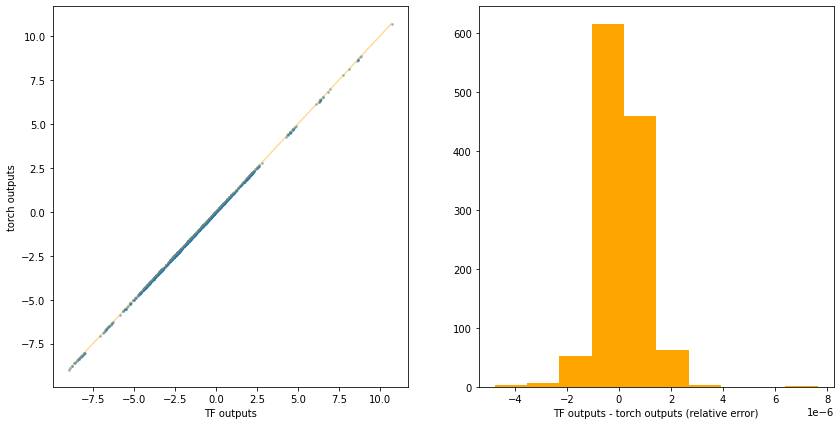

In [216]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
axes[0].scatter(tf_outputs, torch_outputs, alpha=0.4, s=3)
axes[0].plot([tf_outputs.min(), tf_outputs.max()], [tf_outputs.min(), tf_outputs.max()], alpha=0.4, color='orange')
axes[0].set_ylabel("torch outputs")
axes[0].set_xlabel("TF outputs")
axes[1].hist(tf_outputs - torch_outputs, color="orange")
axes[1].set_xlabel("TF outputs - torch outputs (relative error)")

### Try the same in training mode

In [217]:
torch_model.model.train();

In [218]:
torch_outputs = []
tf_outputs = []
for i in range(100):  # for a 100 raw examples
#     np_graph = pipeline.prepare_example(raw_examples[i][0])
    torch_graph = data_converter.prepare_exprtab(raw_examples[i][0])
    
    # -- Convert examples
    # First make a TF input batch
    tf_input, _ = prepare_tf_input(raw_examples[i])
    
    tf_output = tf_model.keras_model(tf_input, training=True)
    tf_outputs.append(tf_output.numpy().ravel())
    
    torch_batch = MultiEdgeTypeBatch.from_data_list([torch_graph])

    torch_model.model.eval()
    torch_output = torch_model.model(torch_batch)
    torch_outputs.append(torch_output.detach().numpy().ravel())


In [219]:
tf_outputs = np.concatenate(tf_outputs)
torch_outputs = np.concatenate(torch_outputs)

Text(0.5, 0, 'TF outputs - torch outputs (relative error)')

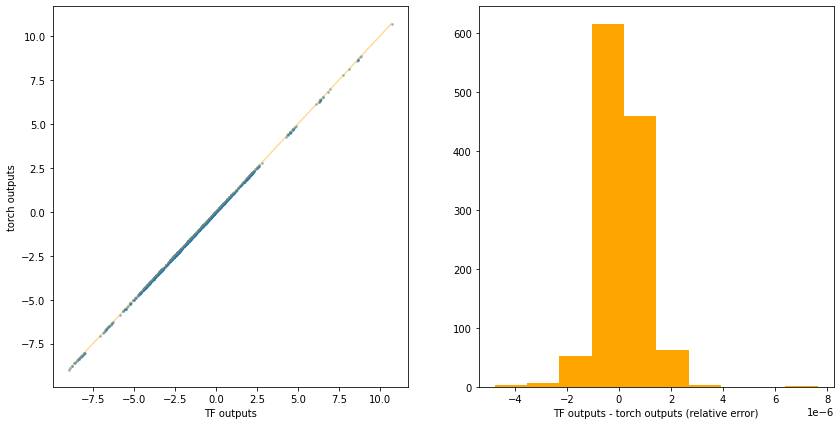

In [220]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
axes[0].scatter(tf_outputs, torch_outputs, alpha=0.4, s=3)
axes[0].plot([tf_outputs.min(), tf_outputs.max()], [tf_outputs.min(), tf_outputs.max()], alpha=0.4, color='orange')
axes[0].set_ylabel("torch outputs")
axes[0].set_xlabel("TF outputs")
axes[1].hist(tf_outputs - torch_outputs, color="orange")
axes[1].set_xlabel("TF outputs - torch outputs (relative error)")

### Compare gradients (hopefully the same at every level)

In [221]:
torch_model.model.train();

In [222]:
tf_input, _ = prepare_tf_input(raw_examples[0])
torch_graph = data_converter.prepare_exprtab(raw_examples[0][0])
torch_batch = MultiEdgeTypeBatch.from_data_list([torch_graph])

In [223]:
torch_model.model.zero_grad()
torch_output = torch_model.model(torch_batch)
print(torch_output)
torch_loss = torch_output.sum()
print(torch_loss)
torch_loss.backward()

tensor([[-0.2087, -0.0333, -0.2832, -0.1323, -0.2199, -0.3308, -0.2474, -0.2211,
         -0.1527, -0.3696, -0.3177, -0.3157]], grad_fn=<ScatterAddBackward>)
tensor(-2.8324, grad_fn=<SumBackward0>)


In [242]:
# Get torch embedding gradient
torch_embedding_grad = torch_model.model.encoder.embedding.weight.grad
torch_embedding_grad_indices = torch.where(torch_embedding_grad.sum(dim=1) != 0.)[0]
torch_embedding_grad_values = torch_embedding_grad[torch_embedding_grad_indices]

# Get torch gradients for message layer [0]
torch_message_grad = torch_model.model.encoder.gnn.gnn_blocks[0].edge_transformations[0].weight.grad

# Get torch gradients for RNN recurrent weight
torch_rnn_weight_hh_grad = torch_model.model.encoder.gnn.gnn_blocks[0].rnn.weight_hh.grad

In [244]:
with tf.GradientTape() as tape:
    tf_output = tf_model.keras_model(tf_input, training=True)
    print(tf_output)
    loss = tf.reduce_sum(tf_output)
    print(loss)
    grad = tape.gradient(loss, tf_model.keras_model.trainable_weights)

tf.Tensor(
[[-0.20867896 -0.03333505 -0.2831657  -0.13234857 -0.21985659 -0.3307803
  -0.24736734 -0.22110274 -0.15271078 -0.36964387 -0.31765762 -0.3157018 ]], shape=(1, 12), dtype=float32)
tf.Tensor(-2.8323493, shape=(), dtype=float32)


In [243]:
def get_tf_gradient_by_name(name, gradient_list, keras_model):
    idx = next(i for i, v in enumerate(keras_model.trainable_weights) if v.name == name)
    return gradient_list[idx]

In [245]:
# Get the embedding layer gradient
embedding_grad = get_tf_gradient_by_name('sparse_gnn_encoder/embedding/embeddings:0', grad, tf_model.keras_model)
shape = get_param_by_name(tf_model.keras_model, 'sparse_gnn_encoder/embedding/embeddings:0').shape
tf_embedding_grad = tf.scatter_nd(embedding_grad.indices[:, None], embedding_grad.values, shape=shape)
# Get the message layer gradients
tf_message_grad = get_tf_gradient_by_name('sparse_gnn_encoder/sparse_gnn/kernel0:0', grad, tf_model.keras_model)
# Get the rnn recurrent kernel weight gradient
tf_rnn_weight_hh_grad = get_tf_gradient_by_name('sparse_gnn_encoder/sparse_gnn/seeded_gru_cell/recurrent_kernel:0', grad, tf_model.keras_model)

In [280]:
def plot_cumdist(vals, label, ax):
    tmp = np.sort(vals.ravel())
    n = len(tmp)
    ax.step(tmp,np.arange(n) / n, label=label, alpha=0.5)
    ax.set_ylabel('cum prob')
    ax.set_xlabel('value')

def plot_tf_against_torch_tensor(tf_tensor, torch_tensor):
    torch_tensor = torch_tensor.detach().numpy() if not isinstance(torch_tensor, np.ndarray) else torch_tensor 
    tf_tensor = tf_tensor.numpy() if not isinstance(tf_tensor, np.ndarray) else tf_tensor
    fig, axes = plt.subplots(ncols=3, figsize=(14, 5))
    axes[0].scatter(tf_tensor, torch_tensor, s=2, alpha=0.5)
    axes[0].set_xlabel("Tensorflow embedding grads")
    axes[0].set_ylabel("Torch embedding grads")
    axes[1].hist((tf_tensor - torch_tensor).ravel())
    plot_cumdist(tf_tensor, label="tensorflow", ax=axes[2])
    plot_cumdist(torch_tensor, label="Torch", ax=axes[2])
    axes[2].legend()

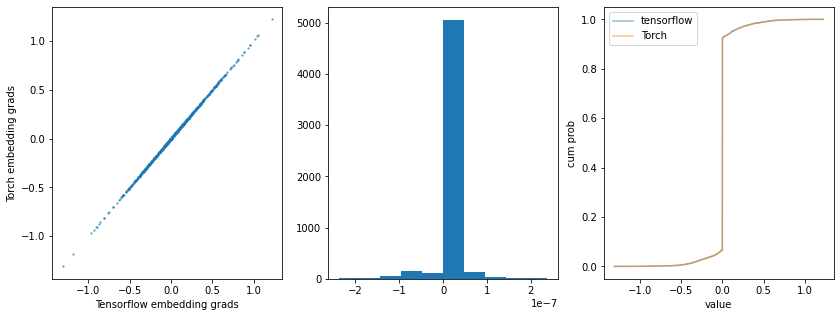

In [263]:
# Plot gradient updates for embeddings against one another
plot_tf_against_torch_tensor(tf_embedding_grad, torch_embedding_grad)

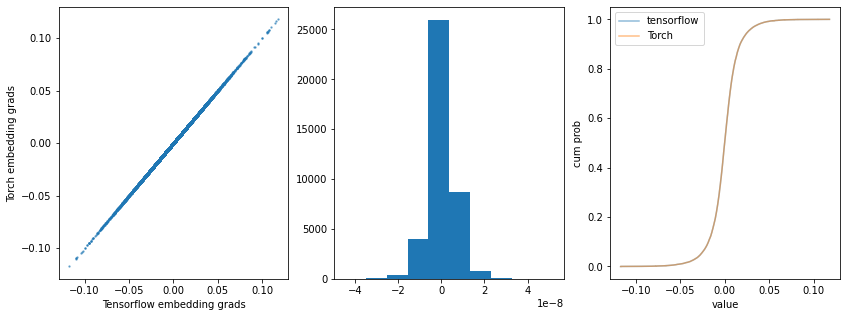

In [265]:
# Plot gradient updates for message kernel against one another
plot_tf_against_torch_tensor(tf_message_grad, torch_message_grad.T)

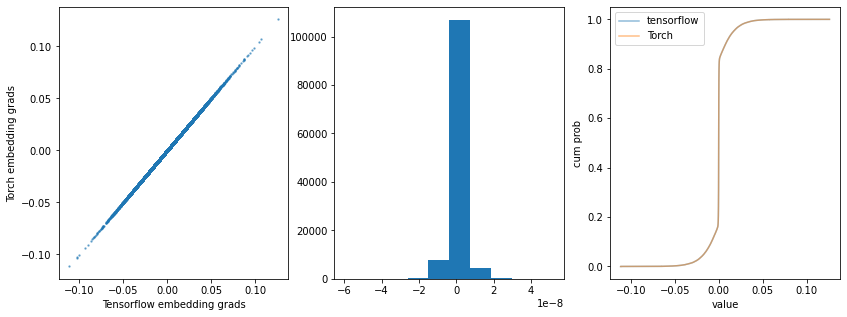

In [270]:
# Plot gradient updates for GRU recurrent kernel against one another
# Rearrange the torch gradient to match TF
r, i, n = torch_rnn_weight_hh_grad.chunk(3, dim=0)
torch_rnn_weight_hh_grad_ordered = torch.cat((i, r, n), dim=0)
plot_tf_against_torch_tensor(tf_rnn_weight_hh_grad, torch_rnn_weight_hh_grad_ordered.T)

# Try executing one step of Adam optim update and see if updates same

### Torch first

In [294]:
torch_model.model.train();
optimizer = torch.optim.Adam(torch_model.model.parameters(), lr=1e-3)

In [295]:
tf_input, _ = prepare_tf_input(raw_examples[0])
torch_graph = data_converter.prepare_exprtab(raw_examples[0][0])
torch_batch = MultiEdgeTypeBatch.from_data_list([torch_graph])

In [296]:
torch_embedding_before_grad = torch_model.model.encoder.embedding.weight.detach().clone().numpy()
num_steps_torch = 0

In [317]:
torch_model.model.zero_grad()
torch_output = torch_model.model(torch_batch)
print(torch_output)
torch_loss = torch_output.sum()
print(torch_loss)
torch_loss.backward()
optimizer.step()

num_steps_torch += 1
print("num_steps:    ", num_steps_torch)

torch_embedding_after_grad  = torch_model.model.encoder.embedding.weight.detach().clone().numpy()

tensor([[ -6.9102,  -9.2543,  -8.5851,  -6.8092, -10.0018, -11.2066,  -9.6905,
          -9.5780,  -4.9650, -14.7016, -12.4484, -12.5167]],
       grad_fn=<ScatterAddBackward>)
tensor(-116.6674, grad_fn=<SumBackward0>)
num_steps:     4


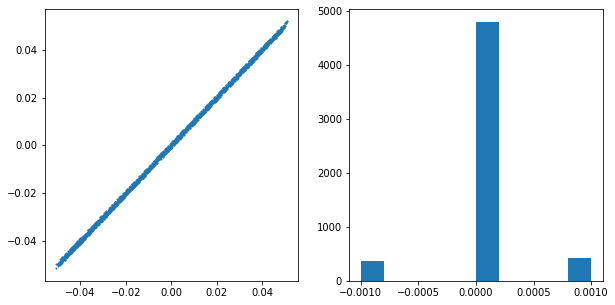

In [306]:
fig, axes =  plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(torch_embedding_before_grad, torch_embedding_after_grad, s=1)
axes[1].hist((torch_embedding_before_grad - torch_embedding_after_grad).ravel());

#### Then tensorflow

In [299]:
tf_optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [300]:
tf_embedding_before_grad = get_param_by_name(tf_model.keras_model, 'sparse_gnn_encoder/embedding/embeddings:0').copy()
num_steps_tf = 0

In [323]:
with tf.GradientTape() as tape:
    tf_output = tf_model.keras_model(tf_input, training=True)
    print(tf_output)
    loss = tf.reduce_sum(tf_output)
    print(loss)
grad = tape.gradient(loss, tf_model.keras_model.trainable_weights)
tf_optimizer.apply_gradients(zip(grad, tf_model.keras_model.trainable_weights))

num_steps_tf += 1
print("num steps:   ", num_steps_tf)

tf_embedding_after_grad = get_param_by_name(tf_model.keras_model, 'sparse_gnn_encoder/embedding/embeddings:0').copy()

tf.Tensor(
[[ -6.9079037  -9.252322   -8.582998   -6.8065114  -9.998901  -11.203304
   -9.687456   -9.576274   -4.9632974 -14.698202  -12.445407  -12.513026 ]], shape=(1, 12), dtype=float32)
tf.Tensor(-116.635605, shape=(), dtype=float32)
num steps:    4


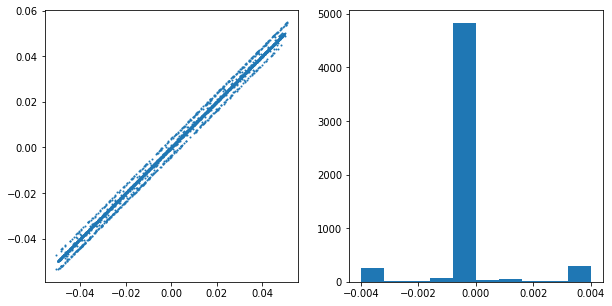

In [325]:
fig, axes =  plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(tf_embedding_before_grad, tf_embedding_after_grad, s=1)
axes[1].hist((tf_embedding_before_grad - tf_embedding_after_grad).ravel());

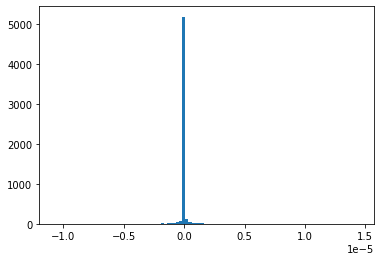

In [326]:
plt.hist((torch_embedding_after_grad - tf_embedding_after_grad).ravel(), bins=100);

### Validate weights the same before gradient update

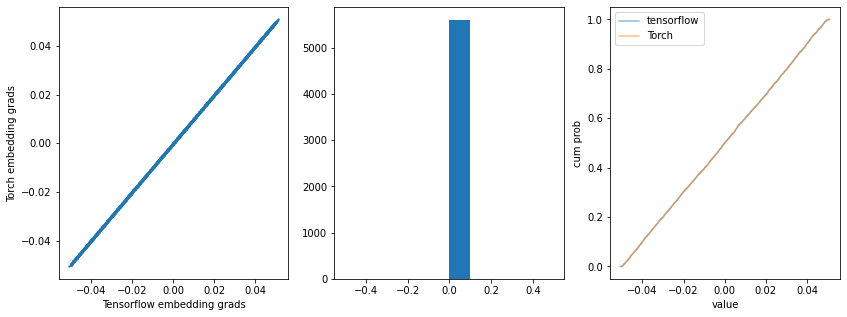

In [327]:
plot_tf_against_torch_tensor(tf_embedding_before_grad, torch_embedding_before_grad)

### Compare weights after gradient update

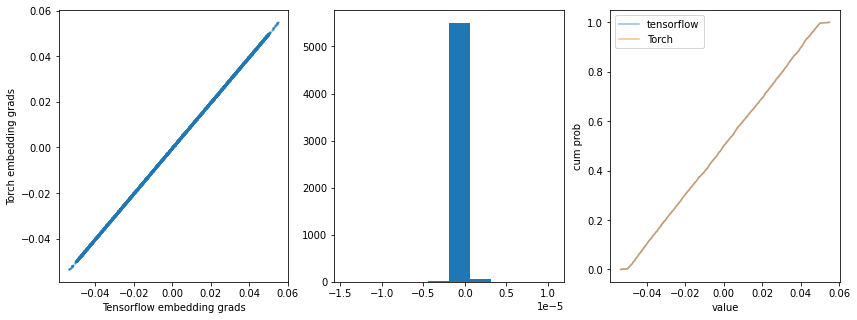

In [328]:
assert num_steps_tf == num_steps_torch
plot_tf_against_torch_tensor(tf_embedding_after_grad, torch_embedding_after_grad)

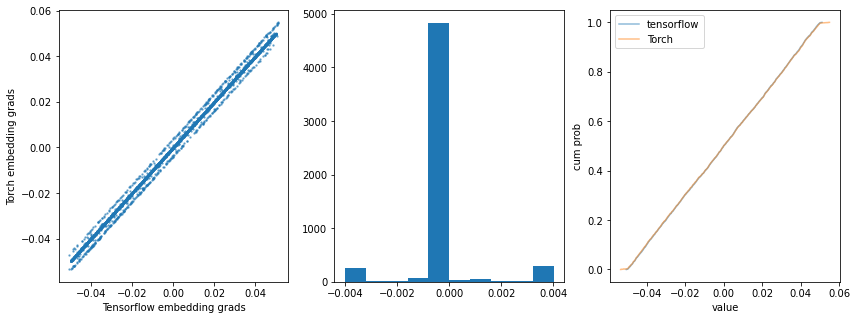

In [329]:
# For validation, make sure the before and after gradient update they are visibly different
plot_tf_against_torch_tensor(tf_embedding_before_grad, torch_embedding_after_grad)